In [1]:
import numpy as np
import math
import random
import os
import torch
import scipy.spatial.distance
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils

import plotly.graph_objects as go
import plotly.express as px

##
import sys
sys.path.append(r"C:\Users\user\OneDrive - personalmicrosoftsoftware.uci.edu\2020Spring\CS175\175PointCloud")
from utils.TDS_utils import read_off, PointSampler, Normalize
from utils.camutils import makerotation, Camera
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.cm as cm
from utils.visutils import set_axes_equal_3d, label_axes

## Get dataset

In [2]:
from path import Path

path = Path("../Data/ModelNet10")
folders = [dir for dir in sorted(os.listdir(path)) if os.path.isdir(path/dir)]
classes = {folder: i for i, folder in enumerate(folders)};
classes

{'bathtub': 0,
 'bed': 1,
 'chair': 2,
 'desk': 3,
 'dresser': 4,
 'monitor': 5,
 'night_stand': 6,
 'sofa': 7,
 'table': 8,
 'toilet': 9}

## sample 3d points

In [3]:
with open(path/"bed/train/bed_0001.off", 'r') as f:
    verts, faces = read_off(f)

In [4]:
# sample points to get (x,y,z) points
pointcloud = PointSampler(1000)((verts, faces))

In [5]:
# Then, range of x,y,z should be between -1 and 1
norm_pointcloud = Normalize()(pointcloud)

In [6]:
norm_pointcloud.shape

(1000, 3)

In [7]:
path = "../Data/ModelNet10"
def get_3d_points(file_name):
    with open(path+'/'+file_name, 'r') as f:
        verts, faces = read_off(f)
        pointcloud = PointSampler(1000)((verts, faces))
        norm_pointcloud = Normalize()(pointcloud)
        return norm_pointcloud.T

## take 2d photo

In [8]:
cam = Camera(f=25,c=np.array([[16,16]]).T,t=np.array([[0,2,0]]).T, R=makerotation(90,0,0))

In [9]:
# project 3d points to get 2d pointss
pts3 = norm_pointcloud.T
pts2 = cam.project(pts3)

In [32]:
def visual_2d(cams: ["cam"], pts3):
    n = len(cams)
    looks = []
    colors = cm.rainbow(np.linspace(0, 1, n))
    
    plt.rcParams['figure.figsize']=[3*n+3,3]
    # visualize pts2 
    fig = plt.figure()
    
    for i in range(n):
        pts2 = cams[i].project(pts3)
        ax = fig.add_subplot(1,n+1,i+1)
        ax.plot(pts2[0,:],pts2[1,:],'.', alpha = 0.3, ms = 5)
        ax.add_patch(patches.Rectangle((0,0),32,32,color='r',fill=False))
#         plt.grid()
        plt.axis('square')
        plt.title('camera'+str(i))
        plt.axis("off")

        # visualize cam 
        looks.append(np.hstack((cams[i].t,cams[i].t+cams[i].R @ np.array([[0,0,0.5]]).T)))
    
    
    ax = fig.add_subplot(1,n+1,n+1,projection='3d')
    ax.plot(pts3[0,:],pts3[1,:],pts3[2,:],'.')
    for i in range(n):
        ax.plot(cams[i].t[0],cams[i].t[1],cams[i].t[2],c = colors[i], marker = 'o', label = "cam"+str(i))
        ax.plot(looks[i][0,:],looks[i][1,:],looks[i][2,:],c = colors[i])

    set_axes_equal_3d(ax)
    label_axes(ax)
    plt.legend()
    plt.title('scene 3D view')
    plt.show()

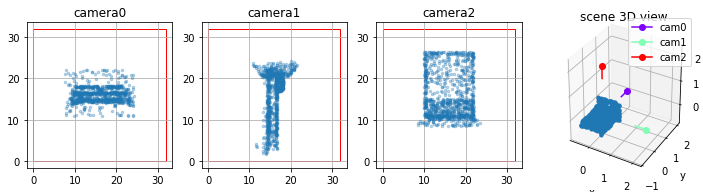

In [11]:
cam1 = Camera(f=25,c=np.array([[16,16]]).T,t=np.array([[0,2,0]]).T, R=makerotation(90,0,0))
cam2 = Camera(f=25,c=np.array([[16,16]]).T,t=np.array([[2,0,0]]).T, R=makerotation(0,90,0))
cam3 = Camera(f=25,c=np.array([[16,16]]).T,t=np.array([[0,0,2]]).T, R=makerotation(180,0,0))
visual_2d([cam1, cam2, cam3], pts3)

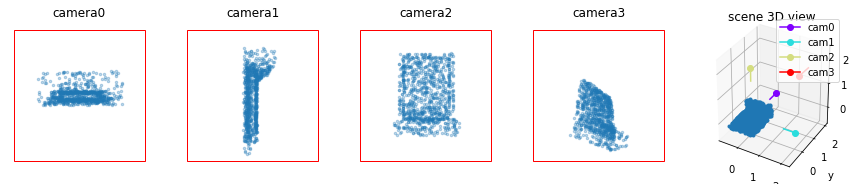

In [53]:
cam1 = Camera(f=25,c=np.array([[16,16]]).T,t=np.array([[0,2,0]]).T, R=makerotation(90,0,0))
cam2 = Camera(f=25,c=np.array([[16,16]]).T,t=np.array([[2,0,0]]).T, R=makerotation(0,90,0))
cam3 = Camera(f=25,c=np.array([[16,16]]).T,t=np.array([[0,0,2]]).T, R=makerotation(180,0,0))
cam4 = Camera(f=25,c=np.array([[16,16]]).T,t=np.array([[1.4,1.4,1.4]]).T, R=makerotation(-45,-45,0))
visual_2d([cam1, cam2, cam3, cam4], pts3)

## Visualize more samples

bed/train/bed_0288.off


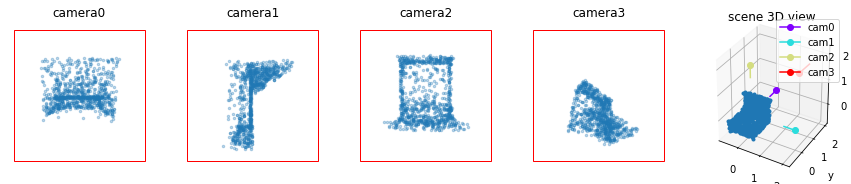

bed/train/bed_0182.off


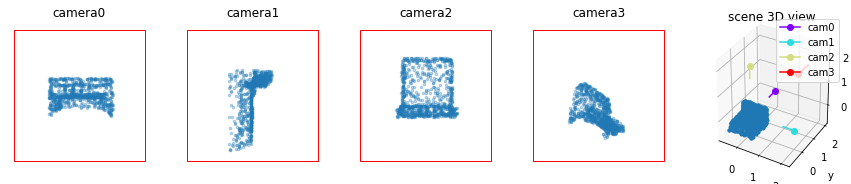

bed/train/bed_0008.off


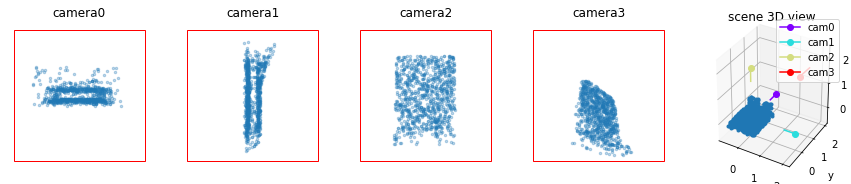

bed/train/bed_0360.off


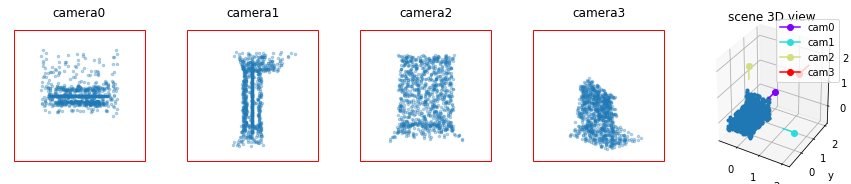

bed/train/bed_0286.off


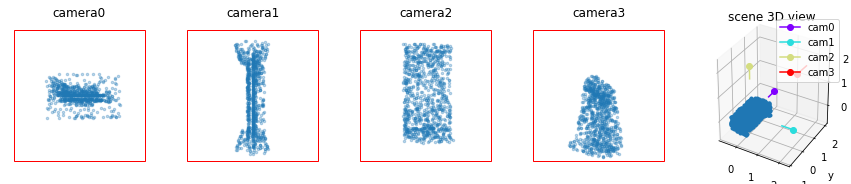

bed/train/bed_0504.off


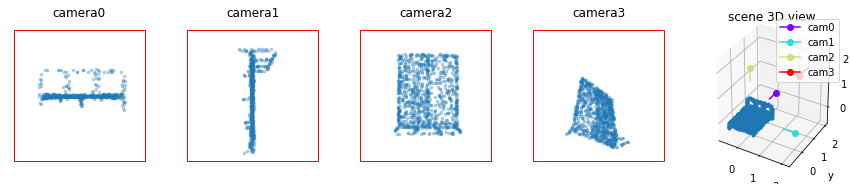

bed/train/bed_0028.off


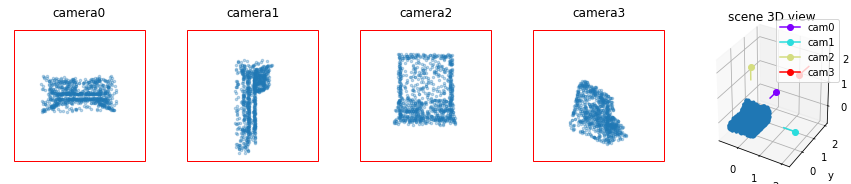

bed/train/bed_0057.off


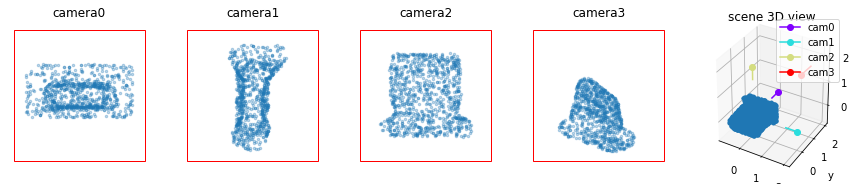

bed/train/bed_0444.off


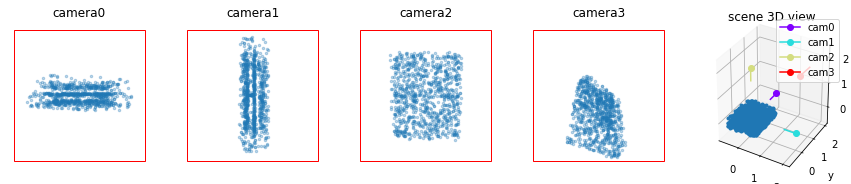

bed/train/bed_0493.off


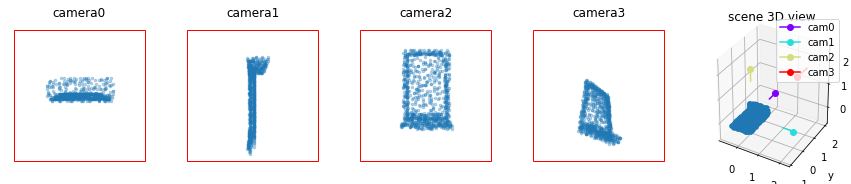

In [54]:
cam1 = Camera(f=25,c=np.array([[16,16]]).T,t=np.array([[0,2,0]]).T, R=makerotation(90,0,0))
cam2 = Camera(f=25,c=np.array([[16,16]]).T,t=np.array([[2,0,0]]).T, R=makerotation(0,90,0))
cam3 = Camera(f=25,c=np.array([[16,16]]).T,t=np.array([[0,0,2]]).T, R=makerotation(180,0,0))
cam4 = Camera(f=25,c=np.array([[16,16]]).T,t=np.array([[1.4,1.4,1.4]]).T, R=makerotation(-45,-45,0))
cams = [cam1,cam2,cam3,cam4]

for i in range(10):
    file_name = "bed/train/bed_" + str(np.random.randint(1,515)).zfill(4) + ".off"
    print(file_name)
    pts3 = get_3d_points(file_name)
    visual_2d(cams, pts3)
    plt.show()

chair/train/chair_0264.off


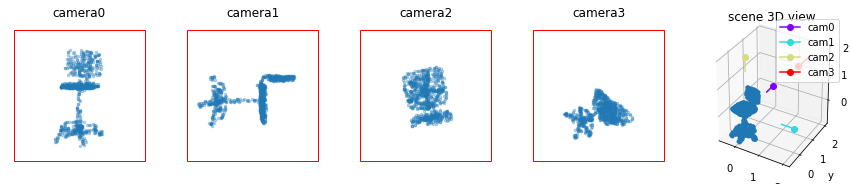

chair/train/chair_0403.off


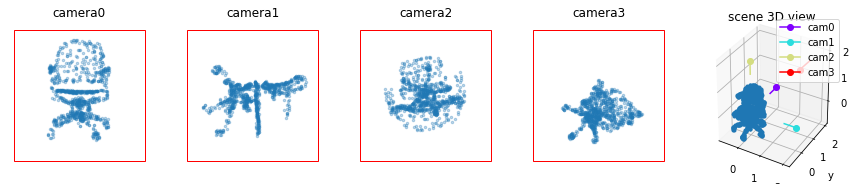

chair/train/chair_0753.off


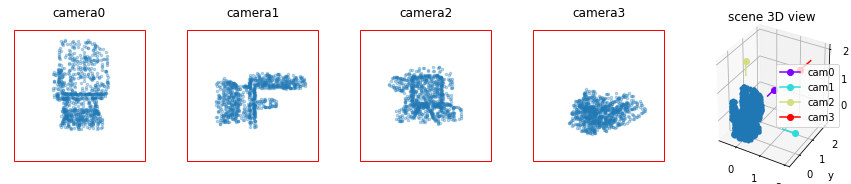

chair/train/chair_0436.off


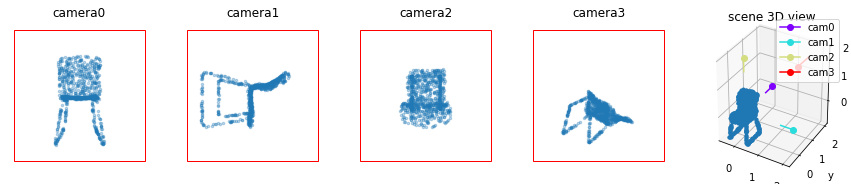

chair/train/chair_0547.off


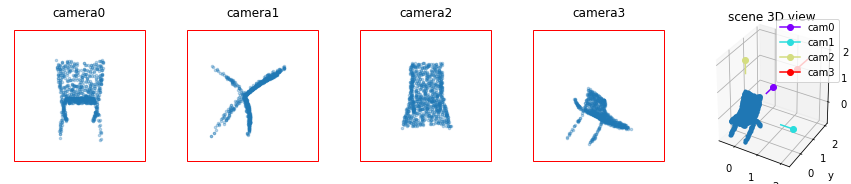

chair/train/chair_0452.off


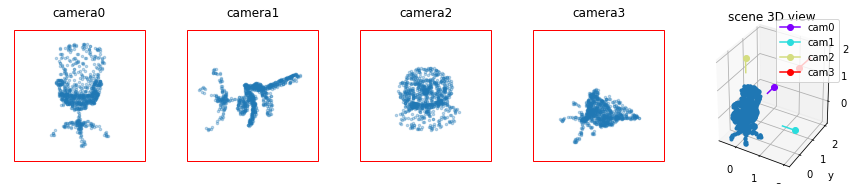

chair/train/chair_0102.off


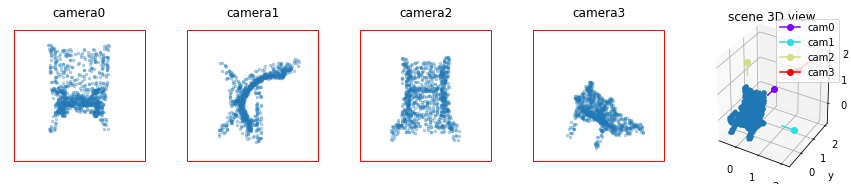

chair/train/chair_0143.off


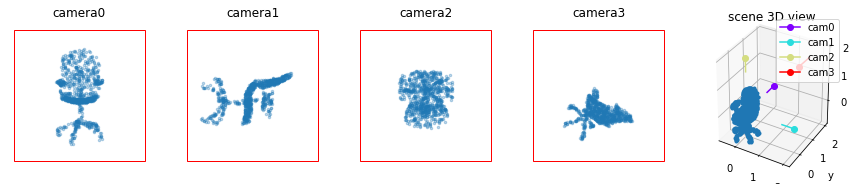

chair/train/chair_0074.off


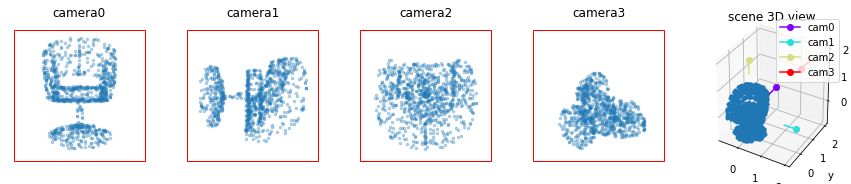

chair/train/chair_0271.off


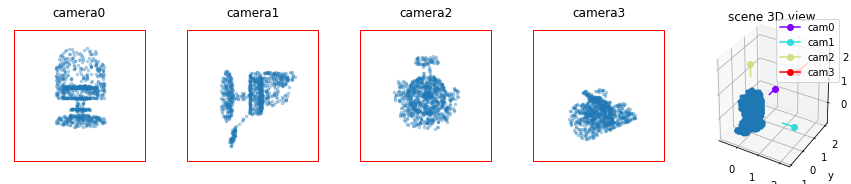

In [38]:
for i in range(10):
    file_name = "chair/train/chair_" + str(np.random.randint(1,889)).zfill(4) + ".off"
    print(file_name)
    pts3 = get_3d_points(file_name)
    visual_2d(cams, pts3)
    plt.show()

## if need to augment data... adding noise

In [39]:
class RandRotation_z(object):
    def __call__(self, pointcloud):
        assert len(pointcloud.shape)==2

        theta = random.random() * 2. * math.pi
        rot_matrix = np.array([[ math.cos(theta), -math.sin(theta),    0],
                               [ math.sin(theta),  math.cos(theta),    0],
                               [0,                             0,      1]])
        
        rot_pointcloud = rot_matrix.dot(pointcloud.T).T
        return  rot_pointcloud
    
class RandomNoise(object):
    def __call__(self, pointcloud):
        assert len(pointcloud.shape)==2

        noise = np.random.normal(0, 0.02, (pointcloud.shape))
    
        noisy_pointcloud = pointcloud + noise
        return  noisy_pointcloud

In [40]:
path = "../Data/ModelNet10"
def get_3d_points_with_noise(file_name):
    with open(path+'/'+file_name, 'r') as f:
        verts, faces = read_off(f)
        pointcloud = PointSampler(1000)((verts, faces))
        norm_pointcloud = Normalize()(pointcloud)
        rot_pointcloud = RandRotation_z()(norm_pointcloud)
        noisy_rot_pointcloud = RandomNoise()(rot_pointcloud)
        return noisy_rot_pointcloud.T

bed/train/bed_0191.off


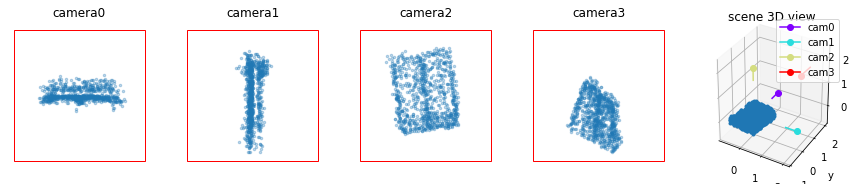

bed/train/bed_0480.off


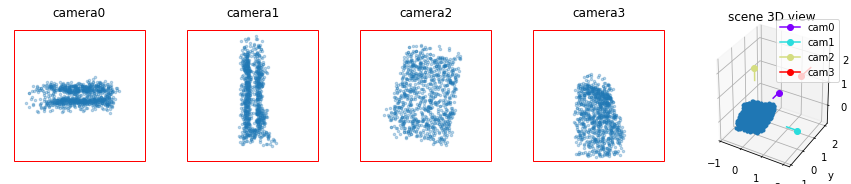

bed/train/bed_0163.off


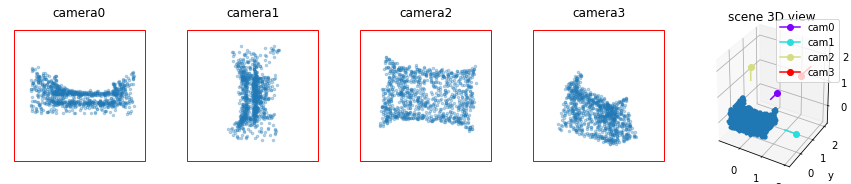

bed/train/bed_0508.off


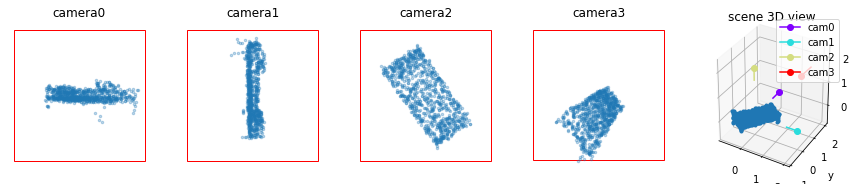

bed/train/bed_0354.off


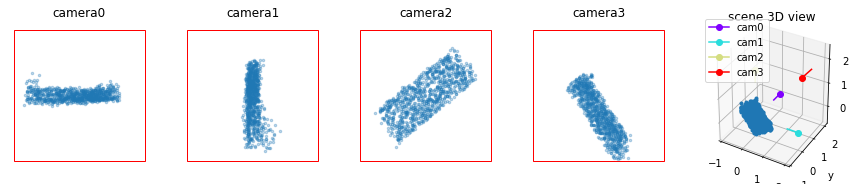

bed/train/bed_0205.off


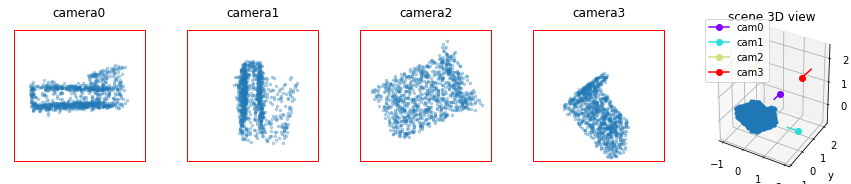

bed/train/bed_0191.off


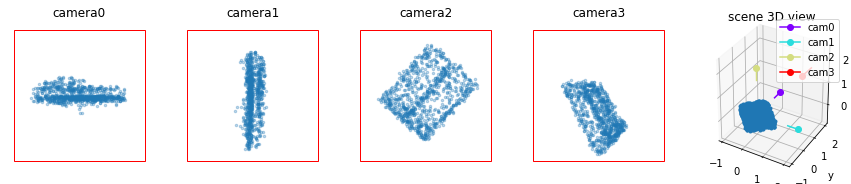

bed/train/bed_0193.off


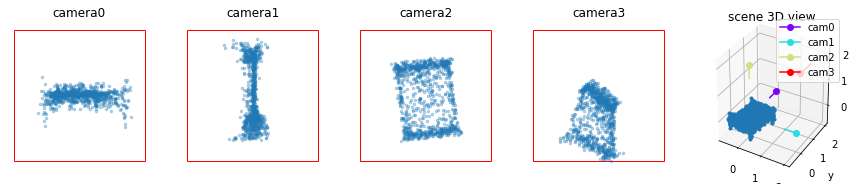

bed/train/bed_0407.off


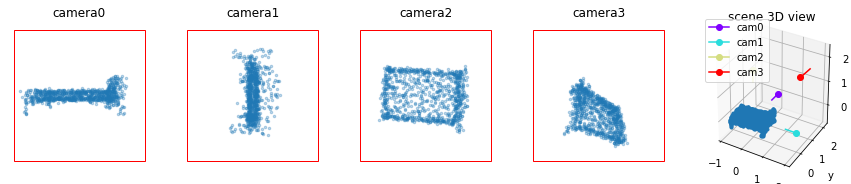

bed/train/bed_0498.off


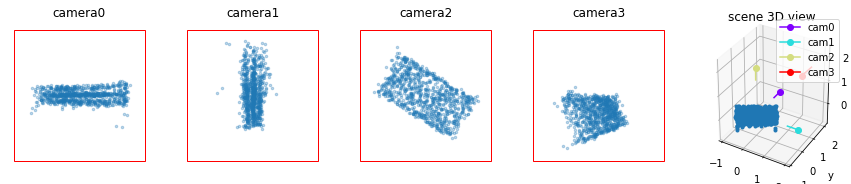

In [41]:
for i in range(10):
    file_name = "bed/train/bed_" + str(np.random.randint(1,515)).zfill(4) + ".off"
    print(file_name)
    pts3 = get_3d_points_with_noise(file_name)
    visual_2d(cams, pts3)
    plt.show()

chair/train/chair_0386.off


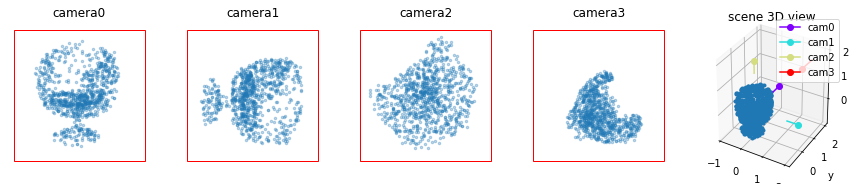

chair/train/chair_0593.off


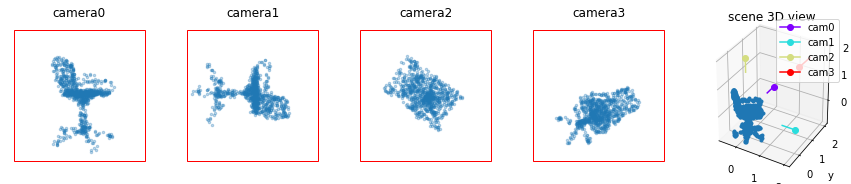

chair/train/chair_0760.off


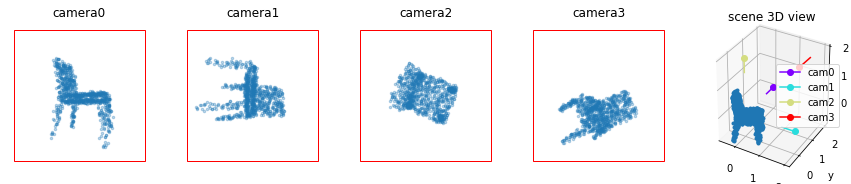

chair/train/chair_0512.off


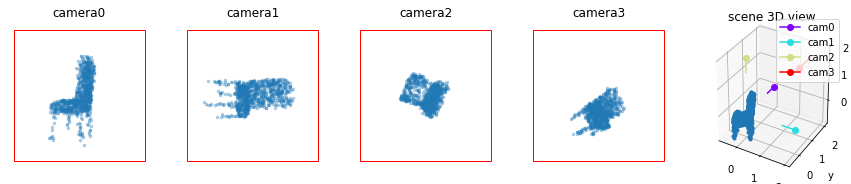

chair/train/chair_0191.off


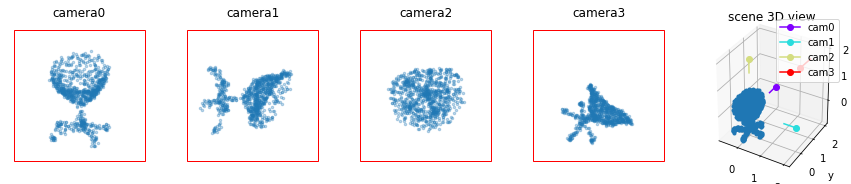

chair/train/chair_0521.off


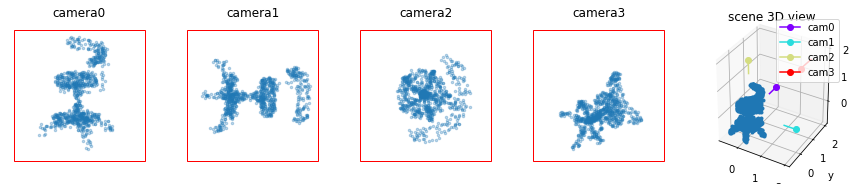

chair/train/chair_0457.off


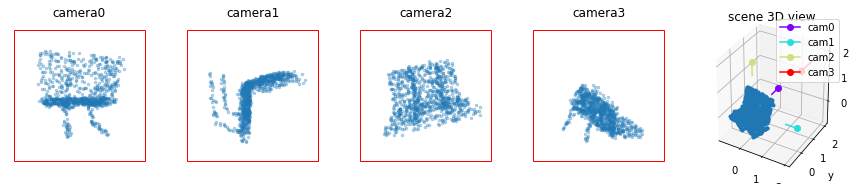

chair/train/chair_0779.off


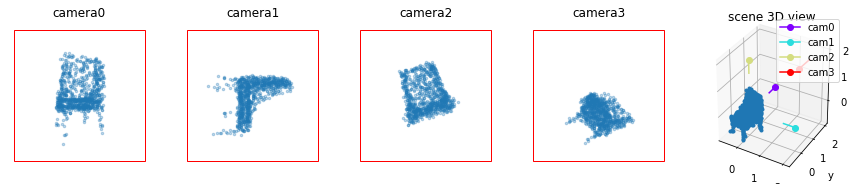

chair/train/chair_0470.off


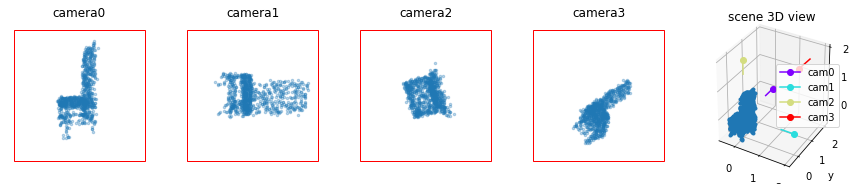

chair/train/chair_0219.off


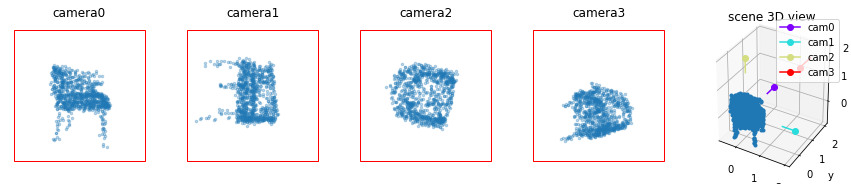

In [42]:
for i in range(10):
    file_name = "chair/train/chair_" + str(np.random.randint(1,889)).zfill(4) + ".off"
    print(file_name)
    pts3 = get_3d_points_with_noise(file_name)
    visual_2d(cams, pts3)
    plt.show()

## Creating data point

In [43]:
class create_data_point(object):
    def __init__(self, cams):
        self.cams = cams
    
    def __call__(self, pointcloud):
        n = len(self.cams)
        pts2 = np.zeros((n,32,32))
        for i in range(n):
            ind = self.cams[i].project(pts3).astype(int).T
            for k,j in ind:
                pts2[i,j,k] += 1

        pts2 /= np.max(pts2)
        return pts2

chair/train/chair_0790.off


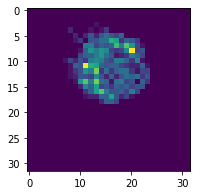

chair/train/chair_0204.off


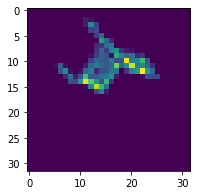

chair/train/chair_0092.off


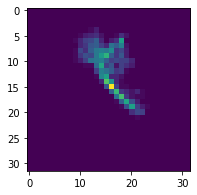

In [45]:
for i in range(3):
    file_name = "chair/train/chair_" + str(np.random.randint(1,889)).zfill(4) + ".off"
    print(file_name)
    pts3 = get_3d_points_with_noise(file_name)
    pts2 = create_data_point(cams)(pts3)
    plt.imshow(pts2[3,:,:])
    plt.show()

## Creating data set

In [49]:
class ToTensor(object):
    def __call__(self, pointcloud):
        return torch.from_numpy(pointcloud)

In [50]:
cam1 = Camera(f=25,c=np.array([[16,16]]).T,t=np.array([[0,2,0]]).T, R=makerotation(90,0,0))
cam2 = Camera(f=25,c=np.array([[16,16]]).T,t=np.array([[2,0,0]]).T, R=makerotation(0,90,0))
cam3 = Camera(f=25,c=np.array([[16,16]]).T,t=np.array([[0,0,2]]).T, R=makerotation(180,0,0))
cams = [cam1,cam2,cam3]


train_transforms = transforms.Compose([
                    PointSampler(1024),
                    Normalize(),
                    RandRotation_z(),
                    RandomNoise(),
                    create_data_point(cams),
                    ToTensor()
                    ])
def default_transforms():
    return transforms.Compose([
                    PointSampler(1024),
                    Normalize(),
                    create_data_point(cams),
                    ToTensor()
                    ])

In [51]:
class PointCloudData(Dataset):
    def __init__(self, root_dir, valid=False, folder="train", transform=default_transforms()):
        self.root_dir = root_dir
        folders = [dir for dir in sorted(os.listdir(root_dir)) if os.path.isdir(root_dir/dir)]
        self.classes = {folder: i for i, folder in enumerate(folders)}
        self.transforms = transform if not valid else default_transforms()
        self.valid = valid
        self.files = []
        for category in self.classes.keys():
            new_dir = root_dir/Path(category)/folder
            for file in os.listdir(new_dir):
                if file.endswith('.off'):
                    sample = {}
                    sample['pcd_path'] = new_dir/file
                    sample['category'] = category
                    self.files.append(sample)

    def __len__(self):
        return len(self.files)

    def __preproc__(self, file):
        verts, faces = read_off(file)
        if self.transforms:
            pointcloud = self.transforms((verts, faces))
        return pointcloud

    def __getitem__(self, idx):
        pcd_path = self.files[idx]['pcd_path']
        category = self.files[idx]['category']
        with open(pcd_path, 'r') as f:
            pointcloud = self.__preproc__(f)
        return {'pointcloud': pointcloud, 
                'category': self.classes[category]}

In [52]:
train_ds = PointCloudData(Path(path), transform=train_transforms)
valid_ds = PointCloudData(Path(path), valid=True, folder='test', transform=train_transforms)

In [53]:
inv_classes = {i: cat for cat, i in train_ds.classes.items()};
inv_classes

{0: 'bathtub',
 1: 'bed',
 2: 'chair',
 3: 'desk',
 4: 'dresser',
 5: 'monitor',
 6: 'night_stand',
 7: 'sofa',
 8: 'table',
 9: 'toilet'}

In [54]:
print('Train dataset size: ', len(train_ds))
print('Valid dataset size: ', len(valid_ds))
print('Number of classes: ', len(train_ds.classes))
print('Sample pointcloud shape: ', train_ds[0]['pointcloud'].size())
print('Class: ', inv_classes[train_ds[0]['category']])

Train dataset size:  3991
Valid dataset size:  908
Number of classes:  10
Sample pointcloud shape:  torch.Size([3, 32, 32])
Class:  bathtub


## Try Resnet

In [55]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
from torch.utils.data import DataLoader
from torch.utils.data import sampler

import torchvision.datasets as dset
import torchvision.transforms as T

import numpy as np

In [56]:
# 3x3 convolution
def conv3x3(in_channels, out_channels, stride=1):
    return nn.Conv2d(in_channels, out_channels, kernel_size=3, 
                     stride=stride, padding=1, bias=False)

# Residual block
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super(ResidualBlock, self).__init__()
        self.conv1 = conv3x3(in_channels, out_channels, stride)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(out_channels, out_channels)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.downsample = downsample
        
    def forward(self, x):
        residual = x
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        if self.downsample:
            residual = self.downsample(x)
        out += residual
        out = self.relu(out)
        return out

# ResNet
class ResNet(nn.Module):
    def __init__(self, block, layers, num_classes=10):
        super(ResNet, self).__init__()
        self.in_channels = 16
        self.conv = conv3x3(3, 16)
        self.bn = nn.BatchNorm2d(16)
        self.relu = nn.ReLU(inplace=True)
        self.layer1 = self.make_layer(block, 16, layers[0])
        self.layer2 = self.make_layer(block, 32, layers[1], 2)
        self.layer3 = self.make_layer(block, 64, layers[2], 2)
        self.avg_pool = nn.AvgPool2d(8)
        self.fc = nn.Linear(64, num_classes)
        
    def make_layer(self, block, out_channels, blocks, stride=1):
        downsample = None
        if (stride != 1) or (self.in_channels != out_channels):
            downsample = nn.Sequential(
                conv3x3(self.in_channels, out_channels, stride=stride),
                nn.BatchNorm2d(out_channels))
        layers = []
        layers.append(block(self.in_channels, out_channels, stride, downsample))
        self.in_channels = out_channels
        for i in range(1, blocks):
            layers.append(block(out_channels, out_channels))
        return nn.Sequential(*layers)
    
    def forward(self, x):
        out = self.conv(x)
        out = self.bn(out)
        out = self.relu(out)
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.avg_pool(out)
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        return out

In [57]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [58]:
pointnet = ResNet(ResidualBlock, [2, 2, 2])
pointnet.to(device)

ResNet(
  (conv): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (layer1): Sequential(
    (0): ResidualBlock(
      (conv1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): ResidualBlock(
      (conv1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=

In [59]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(pointnet.parameters(), lr=0.001)

In [60]:
train_loader = DataLoader(dataset=train_ds, batch_size=32, shuffle=True)
valid_loader = DataLoader(dataset=valid_ds, batch_size=64)

In [77]:
def train(model, loss_fn, optimizer, num_epochs = 1, save = False):
    for epoch in range(num_epochs):
        print('Starting epoch %d / %d' % (epoch + 1, num_epochs))
        model.train()
        for t, data in enumerate(train_loader):
            x_var, y_var = data['pointcloud'].to(device).float(), data['category'].to(device)

            scores = model(x_var)
            
            loss = loss_fn(scores, y_var)
            if (t + 1) % 10 == 0:
                print('loss = %.4f' % (loss.data))

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        
        if save:
            torch.save(model.state_dict(), "save_"+str(epoch)+".pth")
    
            
def check_accuracy(model, loader):
    num_correct = 0
    num_samples = 0
    model.eval() # Put the model in test mode (the opposite of model.train(), essentially)
    for i, data in enumerate(loader):
        x_var, y = data['pointcloud'].to(device).float(), data['category']

        scores = model(x_var)
        _, preds = scores.data.cpu().max(1)
        num_correct += (preds == y).sum()
        num_samples += preds.size(0)
    acc = float(num_correct) / num_samples
    print('Got %d / %d correct (%.2f)' % (num_correct, num_samples, 100 * acc))

In [66]:
train(pointnet, loss_fn, optimizer, num_epochs = 10, save = False)

Starting epoch 1 / 10
loss = 2.3769
loss = 2.1544
loss = 2.1855
loss = 2.1901
loss = 2.1739
loss = 2.1208
loss = 1.9456
loss = 2.0445
loss = 2.2278
loss = 2.2167
loss = 2.1384
loss = 2.0354
Starting epoch 2 / 10
loss = 2.3742
loss = 2.1381
loss = 2.0578
loss = 2.1617
loss = 2.1915
loss = 2.1480
loss = 2.0849
loss = 2.0387
loss = 2.0864
loss = 2.0837
loss = 2.1235
loss = 2.3176
Starting epoch 3 / 10
loss = 2.0422
loss = 2.1117
loss = 1.9995
loss = 2.0993
loss = 2.0643
loss = 2.0525
loss = 2.0326
loss = 2.2388
loss = 2.0786
loss = 2.0757
loss = 2.1494
loss = 2.1008
Starting epoch 4 / 10
loss = 2.1012
loss = 2.0464
loss = 1.9384
loss = 2.2402
loss = 2.1187


KeyboardInterrupt: 

In [78]:
check_accuracy(pointnet, valid_loader)

Got 100 / 908 correct (11.01)
